Fitting a neural network to MNIST

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


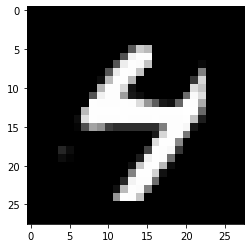

In [3]:
# plot the j-th image
j = 991
fig = plt.figure
plt.imshow(train_images[j], cmap='gray')
plt.show()

In [4]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [5]:
train_images.shape

(60000, 784)

In [ ]:
model = keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ]
)

In [ ]:
model.compile(optimizer="rmsprop", \
              loss = "sparse_catergorical_crossentropy",
              metrics=["accuracy"])

In [7]:
model = keras.Sequential(
    [
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]
)

In [14]:
model.compile(optimizer='rmsprop', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [15]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 12ms/step - loss: 0.2505 - accuracy: 0.9272
Epoch 2/5
469/469 [==============================] - 5s 12ms/step - loss: 0.1016 - accuracy: 0.9697
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0683 - accuracy: 0.9799
Epoch 4/5
469/469 [==============================] - 5s 12ms/step - loss: 0.0498 - accuracy: 0.9849
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0376 - accuracy: 0.9890


In [16]:
model.predict(test_images)

array([[9.1052845e-09, 3.7426461e-11, 1.8570084e-06, ..., 9.9998760e-01,
        2.7989442e-08, 1.2365891e-07],
       [1.0612247e-10, 4.3609975e-07, 9.9999952e-01, ..., 2.2120263e-18,
        1.9425929e-08, 5.3211549e-17],
       [7.7594633e-09, 9.9977869e-01, 2.0589710e-05, ..., 9.5653348e-05,
        9.0392961e-05, 1.9267237e-07],
       ...,
       [1.4545377e-13, 3.8362521e-11, 7.7752034e-11, ..., 3.2495332e-06,
        3.4104539e-06, 1.8298395e-05],
       [3.1098405e-11, 9.4057303e-13, 4.5256994e-14, ..., 7.3526401e-13,
        1.5416289e-06, 1.9282322e-14],
       [7.1914648e-11, 1.1346526e-17, 6.8140645e-12, ..., 5.1079263e-17,
        6.1689201e-13, 1.5669814e-13]], dtype=float32)

# Reimplementing the model from scratch in TensorFlow

## A single layer

$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$

$A^{[l]}=g(Z^{[l]})$


In [25]:
# compose a single layer
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

## Compose the layers together

Each layer is a function

for $l=1,..., L$,

$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$

$A^{[l]}=g(Z^{[l]})$

where $A^{[0]} = X$ for the first layer

In [36]:
# compose the layers together
# take layers one by one, appply recursively to layers 

class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights

        return weights

In [37]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])

In [38]:
assert len(model.weights) == 4

In [39]:
# generate a batch of data
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

## Gradient descent for neural networks

Hand derivations

$dz^{[2]} = a^{[2]} - y$

$dW^{[2]} = dz^{[2]} a^{[1]\top}$

$db^{[2]} = dz^{[2]}$

$dz^{[1]} = W^{[2]\top}dz^{[2]}*g^{[1]'}(z^{[1]})$

$dW^{[1]} = dz^{[1]} x^{\top}$

$db^{[1]} = dz^{[1]}$

Use gradient tape!

In [47]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

## Gradient descent

$W^{[1]} \leftarrow W^{[1]} - \alpha \cdot dW^{[1]}$

$W^{[2]} \leftarrow W^{[2]} - \alpha \cdot dW^{[2]}$

$b^{[1]} \leftarrow b^{[1]} - \alpha \cdot db^{[1]}$

$b^{[2]} \leftarrow b^{[2]} - \alpha \cdot db^{[2]}$

In [ ]:
# learning_rate = 1e-3

In [41]:
def update_weights(gradients, weights):
  for g, w in zip(gradients, weights):
    w.assign_sub(g * learning_rate)


In [42]:
# alternative implementation with optimizers
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate = 1e-3)

def update_weights(gradients, weights):
  optimizer.apply_gradients(zip(gradients, weights))

## The full training loop

In [49]:
def fit(model, images, labels, epochs, batch_size=128):
  for epoch_counter in range(epochs):
    print(f"Epoch {epoch_counter}")
    batch_generator = BatchGenerator(images, labels)
    for batch_counter in range(batch_generator.num_batches):
      images_batch, labels_batch = batch_generator.next()
      loss = one_training_step(model, images_batch, labels_batch)
      if batch_counter % 100 == 0:
        print(f"loss at batch {batch_counter}: {loss:.2f}")

## Fit the model using our implementation from scratch

In [50]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 0.71
loss at batch 100: 0.74
loss at batch 200: 0.64
loss at batch 300: 0.70
loss at batch 400: 0.76
Epoch 1
loss at batch 0: 0.65
loss at batch 100: 0.69
loss at batch 200: 0.59
loss at batch 300: 0.66
loss at batch 400: 0.72
Epoch 2
loss at batch 0: 0.62
loss at batch 100: 0.65
loss at batch 200: 0.55
loss at batch 300: 0.63
loss at batch 400: 0.69
Epoch 3
loss at batch 0: 0.59
loss at batch 100: 0.61
loss at batch 200: 0.52
loss at batch 300: 0.60
loss at batch 400: 0.67
Epoch 4
loss at batch 0: 0.56
loss at batch 100: 0.58
loss at batch 200: 0.50
loss at batch 300: 0.57
loss at batch 400: 0.64
Epoch 5
loss at batch 0: 0.54
loss at batch 100: 0.55
loss at batch 200: 0.48
loss at batch 300: 0.55
loss at batch 400: 0.62
Epoch 6
loss at batch 0: 0.52
loss at batch 100: 0.53
loss at batch 200: 0.46
loss at batch 300: 0.53
loss at batch 400: 0.61
Epoch 7
loss at batch 0: 0.50
loss at batch 100: 0.51
loss at batch 200: 0.44
loss at batch 300: 0.52
loss at batch 40

## Evaluating the model

In [51]:
predictions = model(test_images)

In [52]:
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.85
